In [1]:
from fft.fft import *
from encode.encode import *
from encode.decode import *
from encrypt_decrypt.encrypt import *
from encrypt_decrypt.decrypt import *
from IPython.display import Audio
import matplotlib.pyplot as plt

## Generate a synthetic audio signal

In [2]:
fs = 44100               
duration = 1.0           
t = np.linspace(0, duration, int(fs*duration), endpoint=False)

# A 440 Hz tone with added white noise
x = np.sin(2 * np.pi * 440 * t) + 0.1 * np.random.randn(len(t))

## Listen to the audio signal:

In [3]:
Audio(x, rate=fs)

## Define a smoothing filter (moving average)

In [4]:
filter_size = 101
h = np.ones(filter_size) / filter_size

### Test 1: Audio Signal FFT -> Encode -> Decode -> IFFT

In [5]:
x_small = x[:64]
t_small = t[:64]
M = len(x_small) * 4      
scale = 2**16   
xi = np.exp(2 * np.pi * 1j / M)  

X = FFT1D(x_small) 
encoded_poly = encode(X, scale, M, xi)
X_decoded = decode(encoded_poly, scale, M, xi)
x_rec = IFFT1D(X_decoded)

reconstruction_ok = np.allclose(x_small, x_rec.real, atol=1e-4)
print("Reconstructed small signal matches original:", reconstruction_ok)


Reconstructed small signal matches original: True


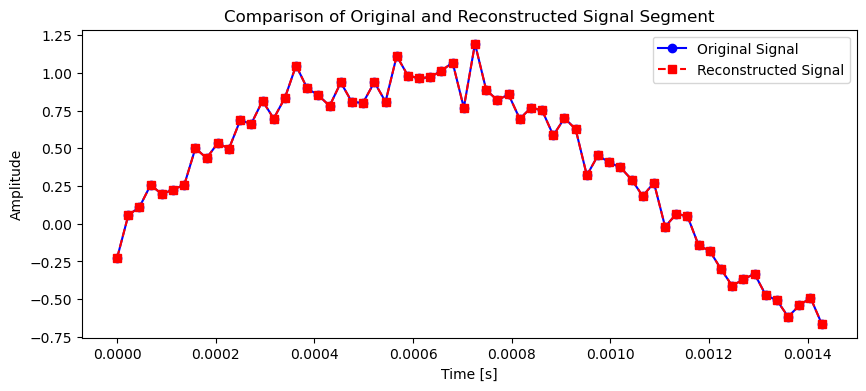

In [6]:
# Plot the original and reconstructed signal segments for visual verification
plt.figure(figsize=(10, 4))
plt.plot(t_small, x_small, 'b-o', label='Original Signal')
plt.plot(t_small, x_rec.real, 'r--s', label='Reconstructed Signal')
plt.title("Comparison of Original and Reconstructed Signal Segment")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()